Text(0.5, 1.0, 'original cover image')

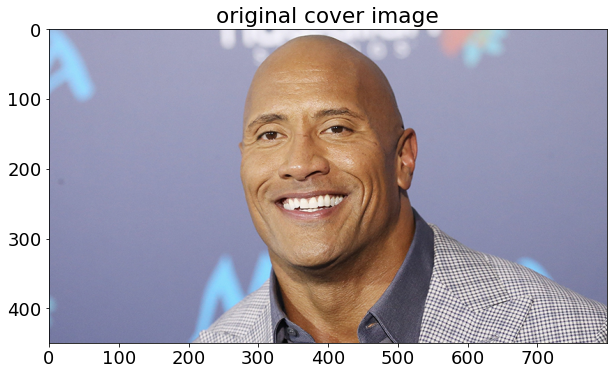

In [1]:
from matplotlib.image import imread
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size':18})

# creating a object 
# PATH = "Steganography\\ImageSources\\jfif\\darth_vader.jfif"
PATH = "Steganography\\ImageSources\\jfif\\the_rock.jfif"
# PATH = "Steganography\\ImageSources\\jfif\\obi-wan_kenobi.jfif"
image = Image.open(PATH)
image.load()
Rot, Grün, Blau= image.split() #split image into its RGB channels
cover_cols, cover_rows = image.size

plt.figure()
plt.imshow(image)
plt.title("original cover image")

In [2]:
string="""It's about drive, it's about power
We stay hungry, we devour
Put in the work, put in the hours and take what's ours (ahoo)
Black and Samoan in my veins
My culture bangin' with Strange
I change the game, so what's my motherfuckin' name (Rock)
(What they gonna get though?)
Desecration, defamation, if you wanna bring it to the masses
Face to face, now we escalatin', when I have to put boots to asses
Mean on ya, like a dream when I'm rumblin', you're gonna scream mama
So bring drama to the King Brahma (then what?) 
Comin' at you with extreme mana"""


""" string version """
def text_to_bits(text, encoding='utf-8', errors='surrogatepass'):
    bits = bin(int.from_bytes(text.encode(encoding, errors), 'big'))[2:]
    return bits.zfill(8 * ((len(bits) + 7) // 8))

def text_from_bits(bits, encoding='utf-8', errors='surrogatepass'):
    n = int(bits,2)
    return n.to_bytes((n.bit_length() + 7) // 8, 'big').decode(encoding, errors) or '\0'

    
""" int version """
def text_to_bits_int(text, gain):
    string_bits = text_to_bits(text)
    # convert each char to int
    return [int(i)*gain for i in string_bits]

def text_from_bits_int(bits):
    # convert each element to string
    string_bits = [str(i) for i in bits]
    string_concat = ""
    # concatenate each element to one string
    for string in string_bits:
        string_concat += string
    string_decode = text_from_bits(string_concat)
    return string_decode


bin_encoded =  text_to_bits_int(string, 2000)


print(bin_encoded[:10])
#bin_encoded=[73,116,39,115,32,97 ,98 ,111 ,117 ,116 ,32 ,100 ,114 ,105 ,118 ,101 ,32 ,105 ,116 ,39 ,115 ,32 ,97 ,98 ,111 ,117 ,116 ,32 ,112 ,111, 119 ,101 ,114]
# bin_decoded = text_from_bits_int(bin_encoded)
# print("bin_decoded:", bin_decoded)

# normalize a channel by its max and min values
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

# convert inverse transformed message to parsable binary message
def message2bin(message, threshold):
    digital = np.zeros(len(message)).astype('uint8')
    for ix, m in enumerate(message):
        if m > threshold:
            digital[ix] = 1
        else:
            digital[ix] = 0
    return digital


[0, 2000, 0, 0, 2000, 0, 0, 2000, 0, 2000]


Embedding hidden message with sort filter

C:\Users\maxik\AppData\Local\Temp/ipykernel_5568/2280318663.py:19: RuntimeWarning: divide by zero encountered in log10
  im = Image.fromarray(20*np.log10(np.fft.fftshift(cover_r_fft_masked)))
C:\Users\maxik\AppData\Local\Temp/ipykernel_5568/2280318663.py:41: RuntimeWarning: divide by zero encountered in log10
  im = Image.fromarray(20*np.log10(np.fft.fftshift(cover_r_fft_abs)))


max value: 255.33184126694235
max value: 255


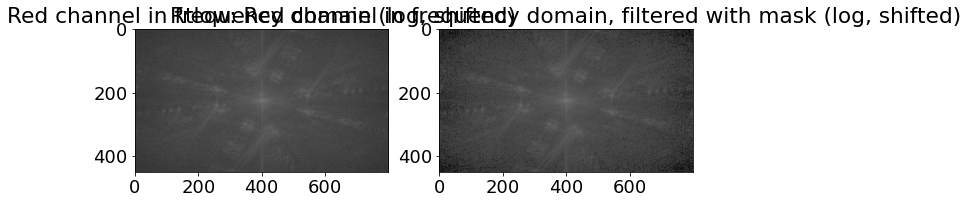

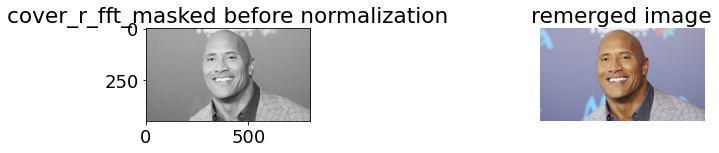

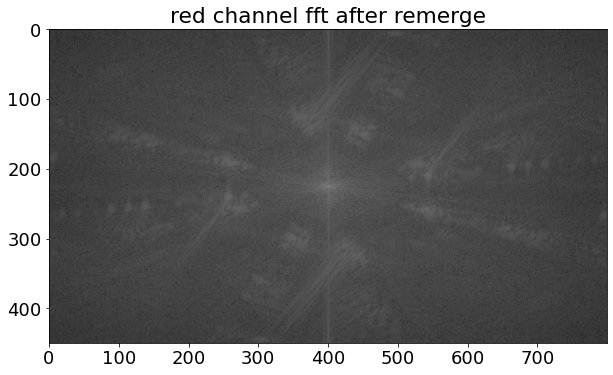

In [3]:
keep=0.95  # 100*(1-keep) is the amount of pixels which will get cut off 

cover_r_fft=np.fft.fft2(Rot)                            #FFT on R Channel
cover_r_fft_abs = np.abs(cover_r_fft)
cover_r_fft_sort=np.sort(cover_r_fft_abs.reshape(-1))         #Convert R Channel Matrix into Vector and sort the frequencies

im = Image.fromarray(20*np.log10(np.fft.fftshift(cover_r_fft_abs)))
plt.figure()
plt.subplot(121)
plt.imshow(im)
plt.title("Red channel in frequency domain (log, shifted)")


#zero out all small coefficients 
#cut off high frequencies from R channel
cover_r_fft_thresh = cover_r_fft_sort[int(np.floor((1-keep)*len(cover_r_fft_sort)))]  
cover_r_fft_mask = np.abs(cover_r_fft)>cover_r_fft_thresh             #filling all with 0 whats over the threshold, else fill with 1
cover_r_fft_masked = cover_r_fft_abs*cover_r_fft_mask                    #//returns low frequencies
im = Image.fromarray(20*np.log10(np.fft.fftshift(cover_r_fft_masked)))
# plt.figure()
plt.subplot(122)
plt.imshow(im)
plt.title("Rtlow: Red channel in frequency domain, filtered with mask (log, shifted)")
#cut off high frequencies from G channel


counter=0
# write hidden message into filtered absolute part
for i in range(image.size[1]):
    for j in range(image.size[0]):
        # write where coefficients are zero -> previously filtered out.
        if cover_r_fft_mask[i,j]==0:
            if counter<len(bin_encoded):
                # write hidden message inside absolute part by overwriting coefficients where the mask is 0
                cover_r_fft_abs[i,j]=bin_encoded[counter]
                # print(cover_r_fft_abs[i,j])
                counter+=1
          

# plot absolute after embedding information
im = Image.fromarray(20*np.log10(np.fft.fftshift(cover_r_fft_abs)))
plt.figure()
plt.imshow(im)
plt.title("Rtlow: Red channel in frequency domain with info embedded (log, shifted)")
#IFFT on R channel. Take filtered absolute and inverse with original phase, imaginary part should be negligable
cover_r_masked =np.fft.ifft2(cover_r_fft_abs*np.exp(1j*np.angle(cover_r_fft))).real
# print(cover_r_masked)


plt.subplot(131)
plt.imshow(cover_r_masked, cmap="gray")
plt.title("cover_r_fft_masked before normalization")
print("max value:", np.max(cover_r_masked))

cover_r_masked_norm = convert(cover_r_masked, 0,255, np.uint8)
plt.subplot(122)
plt.imshow(cover_r_masked_norm, cmap="gray")
plt.title("cover_r_fft_masked after normalization")
print("max value:", np.max(cover_r_masked_norm))

# merge layers
cover_reconstructed =  np.stack((cover_r_masked_norm, Grün, Blau), axis=2).astype('uint8')
img = Image.fromarray(cover_reconstructed)     #create image from remerged matrix


# plt.figure()
plt.subplot(133)
plt.axis('off')
plt.imshow(img) #Show picture with embeddes secret message
plt.title("remerged image")

sanity_check = Image.fromarray(20*np.log10(np.abs(np.fft.fftshift(np.fft.fft2(cover_r_masked)))))
plt.figure()
plt.imshow(sanity_check, cmap="gray")
plt.title("red channel fft after remerge")

im = img.save("Steganography\\ImageSources\\Steganograms\\remerged.png")     #save image as png

Extracting steganogram with previous sort filter

max value stego_r:
 255


C:\Users\maxik\AppData\Local\Temp/ipykernel_5568/1235871489.py:37: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(20*np.log10(np.fft.fftshift(stego_r_fft_mask)), cmap="gray")


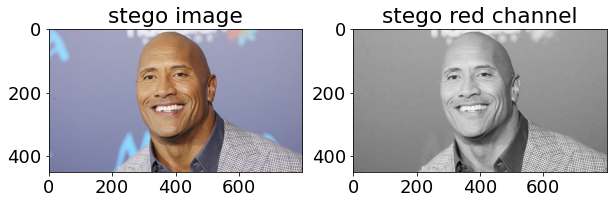

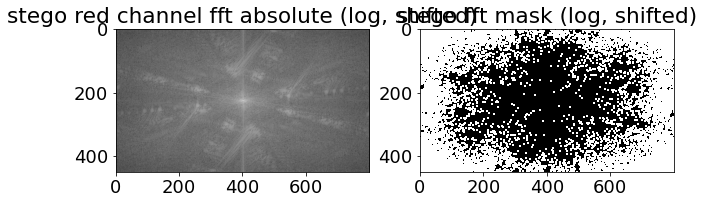

503.9878197453135
3609.9291041315296
340.169272906808
340.16927290681645
3609.9291041315355
503.9878197453568
104.26337881996447
2451.576012682846
209.7071504679266
1904.4300391818065
2104.515614006832
2196.967426212235
257.2657043655472
2045.5839396835133
151.22703025676321
82.5756641509136
138.6989456638874
43.200318195703666
2386.0281483351173
207.22891992674522
216.139971183037
2131.5392506225203
2256.7754505987796
2311.599111185555
117.01148763897118
2035.2177660962582
1933.531419665166
2257.4486283460737
43.219075372904044
186.43990575974112
2167.835532866214
1985.1402022301068
109.05346603761305
150.601881439198
2117.9233961975046
35.98016698583208
153.90778026911588
118.92169241988401
84.83459762967972
89.27952650696521
217.83084311454292
2138.8760984195324
2213.278244257215
147.50018050882062
428.8737127076425
217.70647750693067
31.849311878597273
2319.570586494317
434.1789520262267
2312.829952251326
2247.6772444349276
230.07853816622458
274.3006486233445
153.7346528784513
208

In [4]:
# load and plot image
stego_img = Image.open("Steganography\\ImageSources\\Steganograms\\remerged.png")
plt.figure()
plt.subplot(121)
plt.imshow(stego_img)
plt.title("stego image")

stego_r, stego_g, stego_b = stego_img.split() #split image into its RGB channels

plt.subplot(122)
plt.imshow(stego_r, cmap="gray")
plt.title("stego red channel")

print("max value stego_r:\n", np.max(stego_r))


# transform R channel into frequency domain
stego_r_fft =np.fft.fft2(stego_r)
stego_r_fft_abs = np.abs(stego_r_fft)

plt.figure()
plt.subplot(121)
plt.imshow(20*np.log10(np.fft.fftshift(stego_r_fft_abs)), cmap="gray")
plt.title("stego red channel fft absolute (log, shifted)")

# sort coefficients by value
stego_r_fft_sort=np.sort(np.abs(stego_r_fft.reshape(-1)))

# calculate threshold filter with previous keep
# stego_r_fft_thresh = stego_r_fft_sort[int(np.floor((1-keep)*len(stego_r_fft_sort)))]
# print("threshold:", stego_r_fft_thresh)
# stego_r_fft_mask = np.abs(stego_r_fft)>stego_r_fft_thresh             
stego_r_fft_mask = cover_r_fft_mask

# plt.figure()
plt.subplot(122)
plt.imshow(20*np.log10(np.fft.fftshift(stego_r_fft_mask)), cmap="gray")
plt.title("stego fft mask (log, shifted)")
plt.show()

message=np.zeros(len(bin_encoded), dtype='uint16')
counter=0
#######################

for i in range(image.size[1]):
    for j in range(image.size[0]):
        if stego_r_fft_mask[i,j]==0:
            if counter==len(bin_encoded):
                break
            print(stego_r_fft_abs[i,j])
            message[counter] = stego_r_fft_abs[i,j]
            counter+=1 

binary = message2bin(message, 1000)
Text = text_from_bits_int(binary)
print("bin_decoded:", Text)

[0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]

$\color{green}{\text{Done:}}$
*   dynamic masking + embedding
*   decoder for dynamic masking + embedding
*   'sharp' masking
*   'sharp' embedding


$\color{red}{\text{TODO:}}$
*   'sharp' decoding
*   Rotation test
*   Crop test
*   Compression test
*   Redundant embedding
*   Multichannel
*   Different colorspaces (Lab, YCbCr)

$\color{yellow}{\text{less important:}}$
*   Image payload

Thoughts:
*   pass threshold and search for binaries in +-10 % range
*   plot distribution funtion of absolute fft for easy gain determination
*   embed message into 3 channels -> later add all together and mean the result
    1.  start on same pixel
        if works:
            start each channel on different pixel